# Embedding

In [77]:
import json
import requests


def process_data(data):

    title = data.get('title')
    description = data.get('description')
    maintext = data.get('maintext')

    content = f"""
# {title}
Description: {description}

## Content
{maintext}
"""

    url = 'http://100.68.153.101:11434/api/embeddings'
    response = requests.post(url, json={
        'model': 'bge-m3',
        'prompt': content
    })
    return response.json()

def main(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            if line:
                m = {}
                exec("data = "+line.strip(), m)
                data = m['data']
                processed_data = process_data(data)
                processed_data['title'] = data.get('title')
                processed_data['url'] = data.get('url')
                json.dump(processed_data, outfile)
                outfile.write('\n')

main("files/articles.txt", "files/output.txt")

# Clustering

In [203]:
from urllib.parse import urlparse


data = []
labels = []
def readEmbeddings(input_file):
    with open(input_file, 'r') as infile:
        for line in infile:
            item = json.loads(line)
            data.append(item['embedding'])
            labels.append("  "+item['title'])
            # url = item['url']
            # host = urlparse(url).netloc
            # if url is None:
            #     labels.append('www.smninews.com')
            # else:
            #     labels.append(" " + host)
readEmbeddings("files/output.txt")



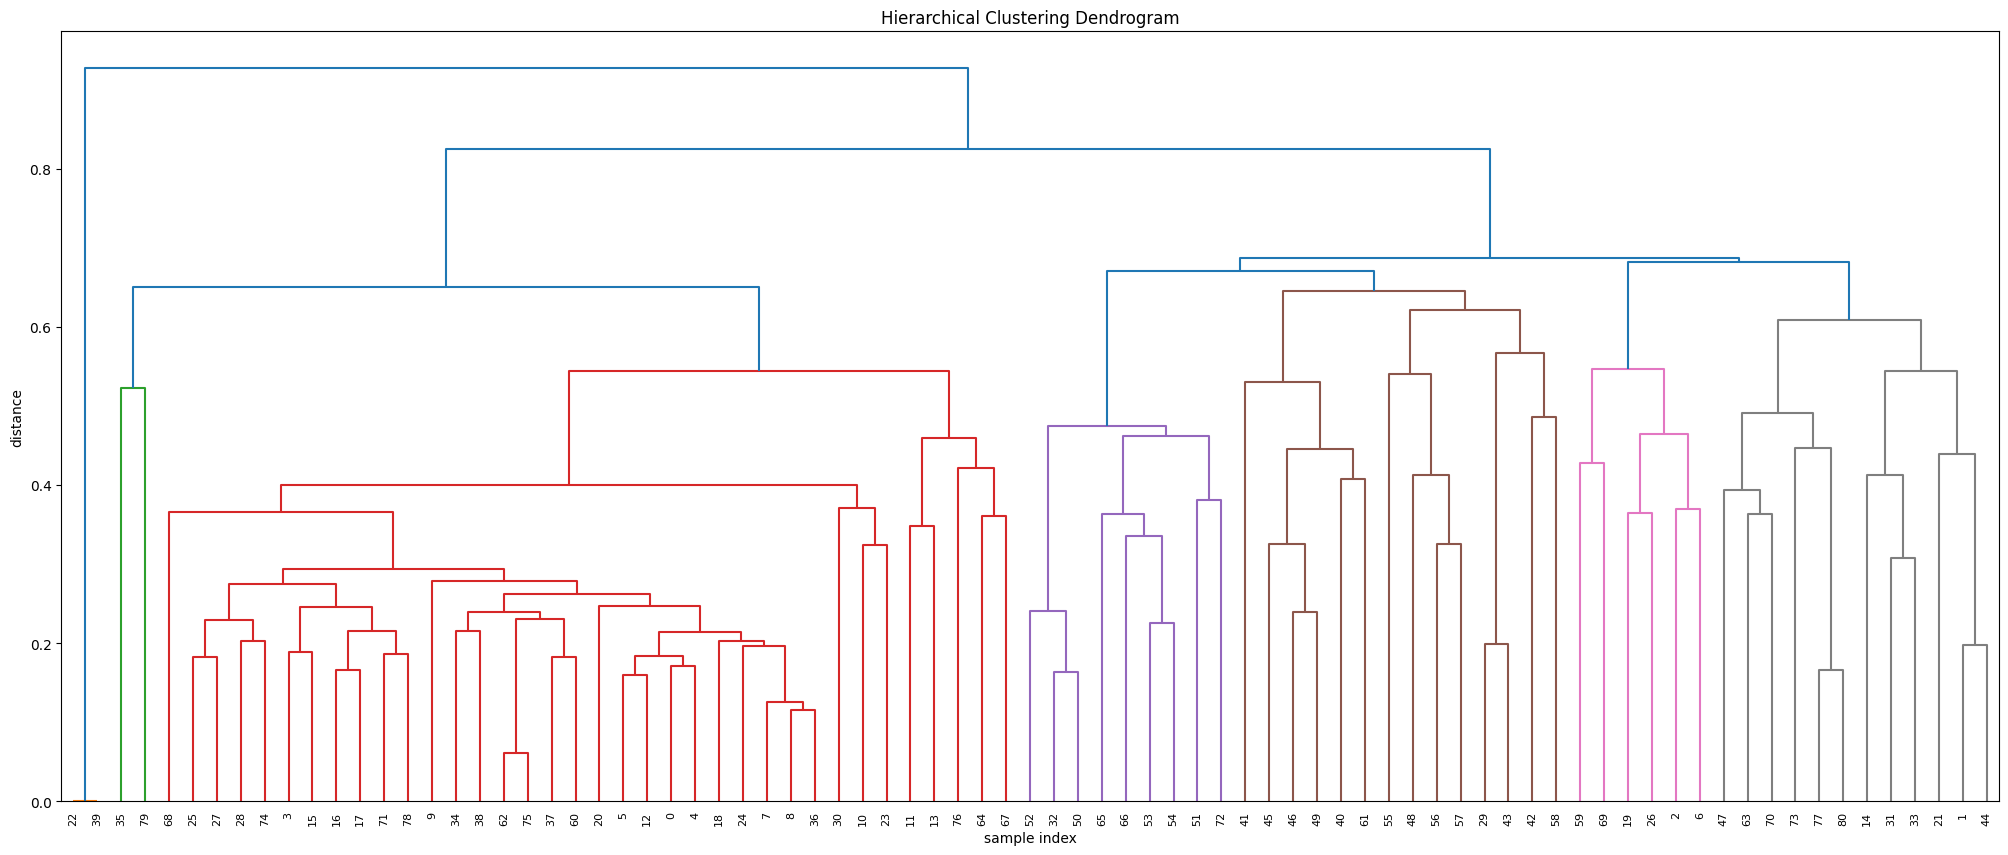

In [222]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

Z = linkage(data, 'complete',metric='cosine')
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

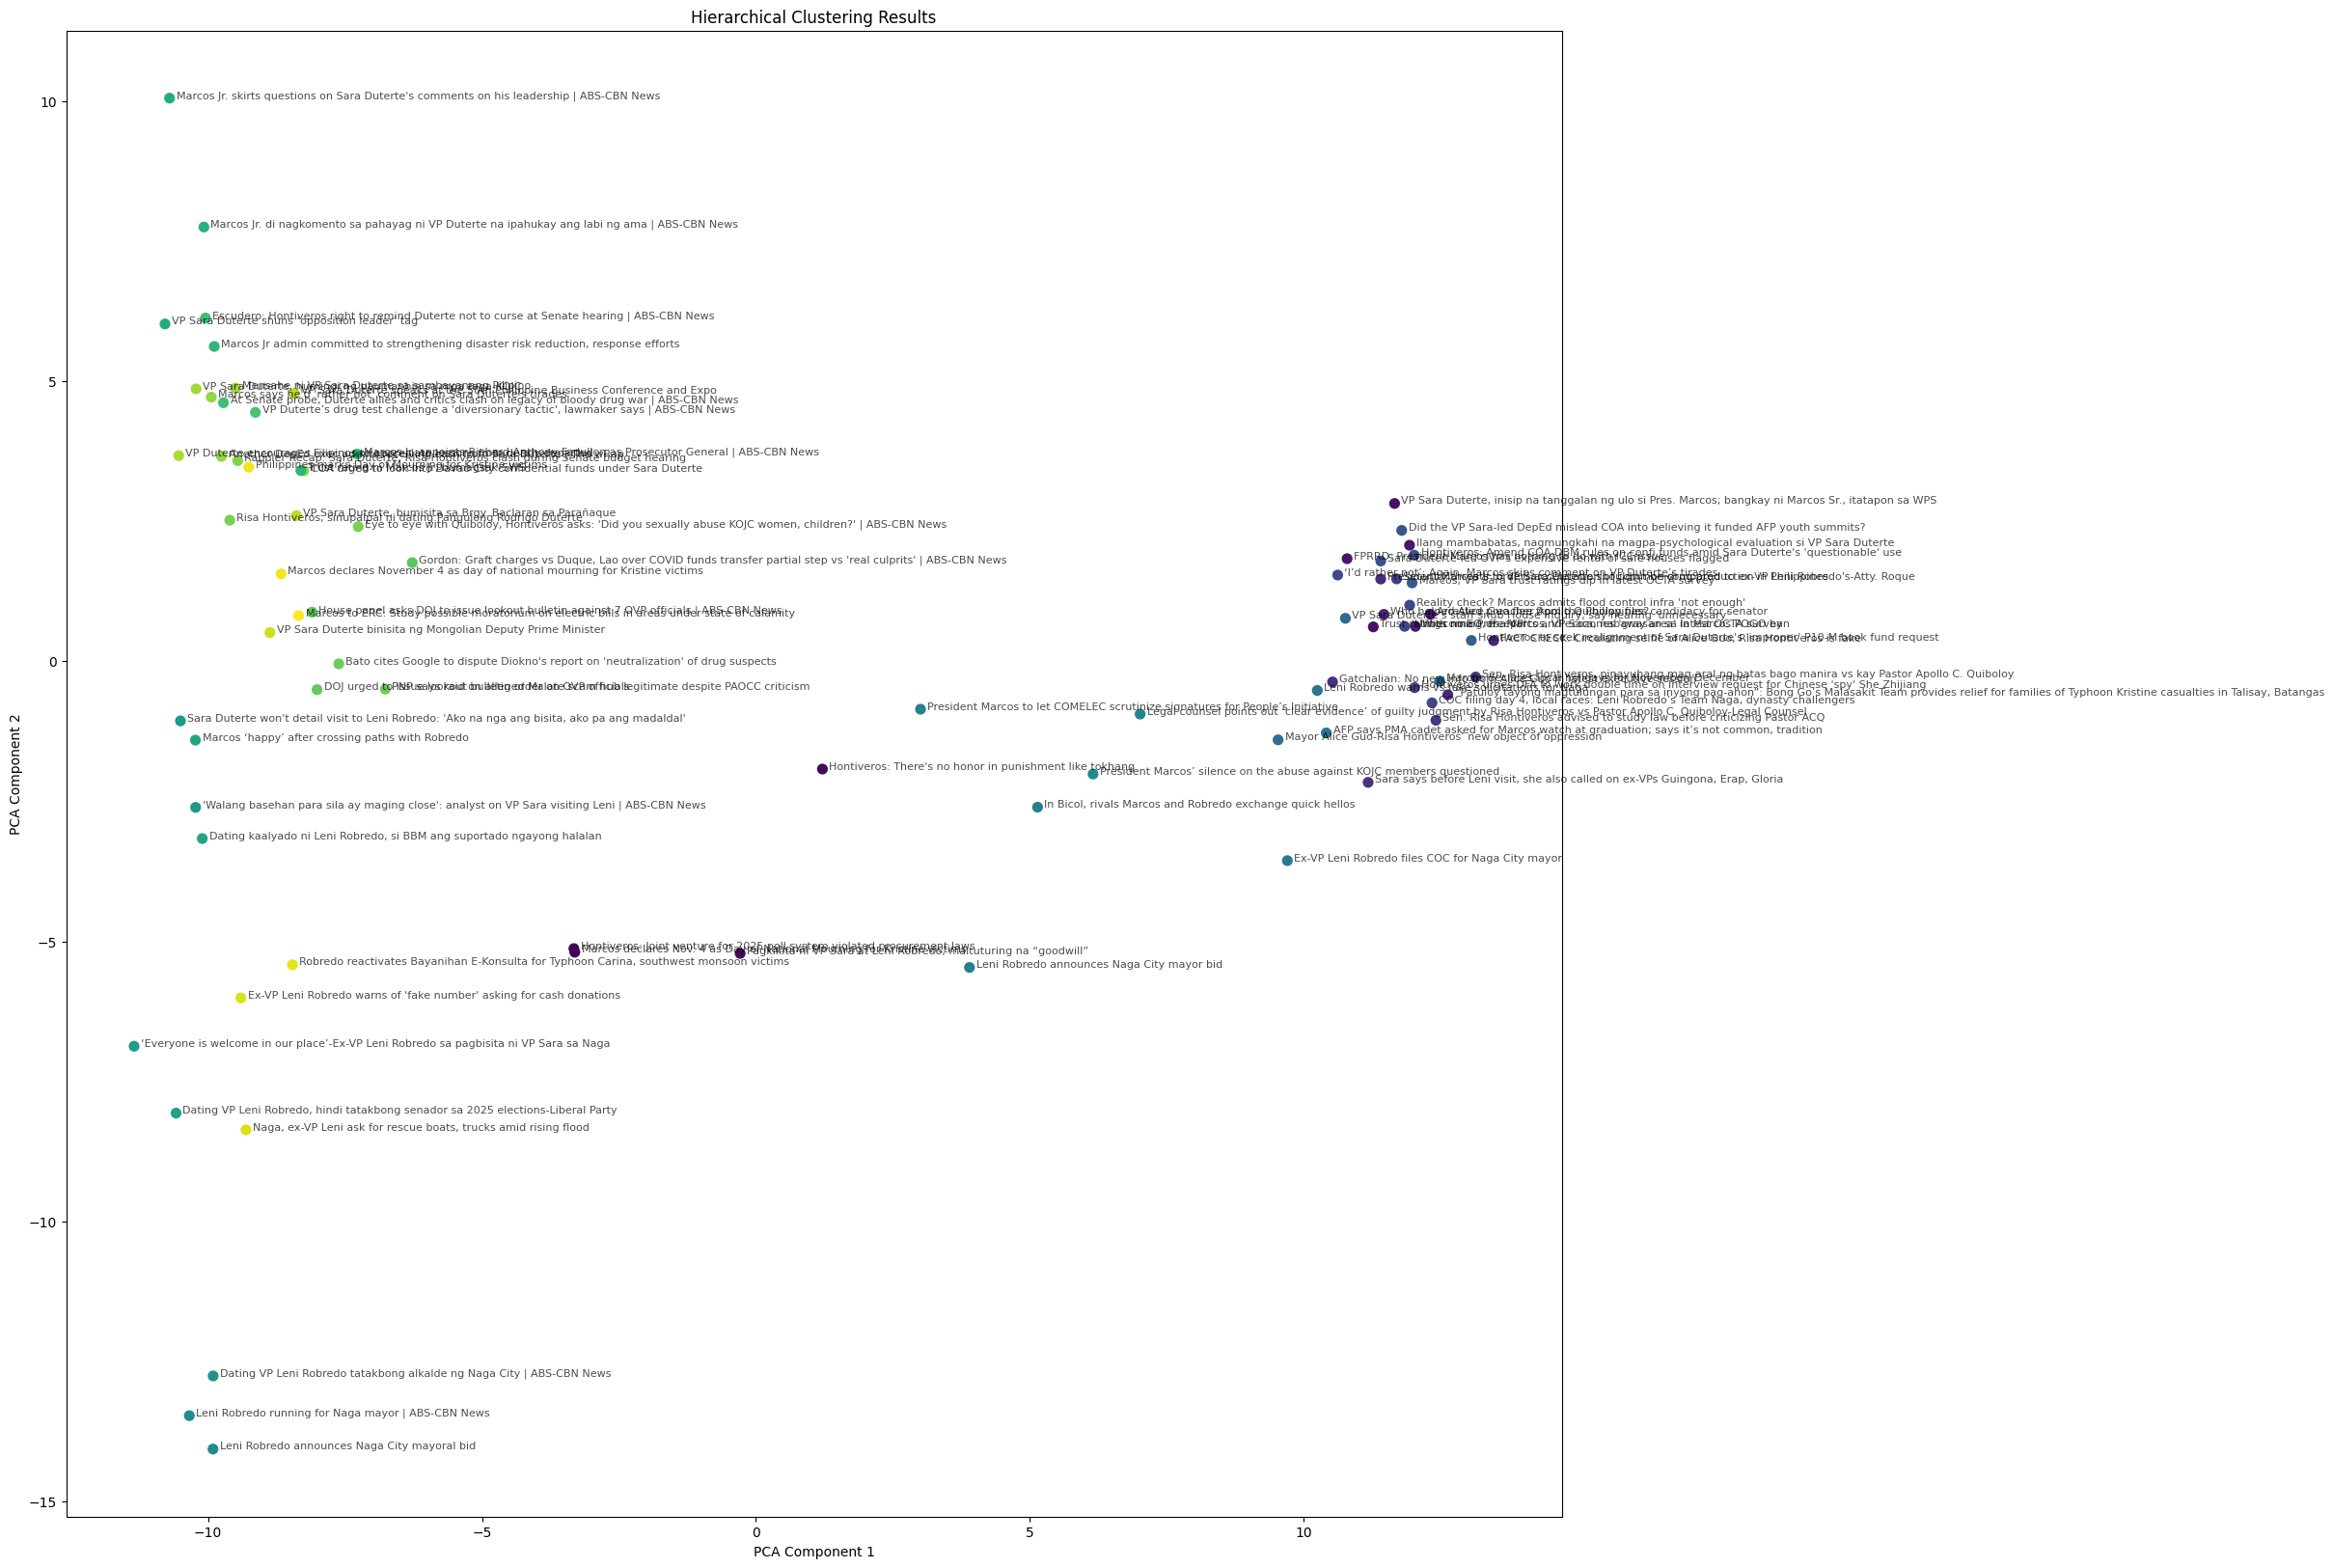

In [223]:
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Set a threshold to form flat clusters
max_d = 0.2 # Adjust this value based on the dendrogram
clusters = fcluster(Z, max_d, criterion='inconsistent')

pca = PCA(n_components=2)
reduced_data = pca.fit_transform(data)

# Plot the clustered data
plt.figure(figsize=(20, 20))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=clusters, cmap='viridis', s=50)
plt.title('Hierarchical Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

for i, label in enumerate(labels):
    plt.annotate(label, (reduced_data[i, 0], reduced_data[i, 1]), fontsize=8, alpha=0.7)

plt.show()

# Topics

In [224]:
import numpy as np
from collections import defaultdict

def summarize_cluster(label_list):
    prompt = f"""
Provide a short and concise headline for the following list of headlines: 
<sentences>\n{ '\n,'.join(label_list) }</sentences>
Your response should be one sentence only.
"""
    url = 'http://100.68.153.101:11434/api/generate'
    response = requests.post(url, json={
        'model': 'llama3',
        'prompt': prompt,
        'stream': False
    })

    res = response.json()
    return res['response']


unique_clusters = np.unique(clusters)


cluster_labels = defaultdict(list)
for idx, cluster in enumerate(clusters):
    cluster_labels[cluster].append(labels[idx])

cluster_summaries = []
for cluster_id in unique_clusters:
    cluster_summaries.append({
        'labels': cluster_labels[cluster_id],
        'Count': len(cluster_labels[cluster_id]),
    })

sorted_summaries = sorted(cluster_summaries, key=lambda x: x['Count'], reverse=True)

headlines = []
for summary in sorted_summaries:
    headline = summarize_cluster( summary['labels'] )
    if ":" in headline:
        headline = headline.split(":")[1].strip()
    print("Coverage: "  + str(summary['Count']) + " - " + headline)
    for label in summary['labels']:
        print( "-" + label)
    print()
    headlines.append(headline)

print(headlines)

Coverage: 2 - "National Mourning Declared for Kristine Victims; Procurement Laws Violated in 2025 Poll System Venture"
-  Marcos declares Nov. 4 as Day of National Mourning for Kristine victims
-  Hontiveros: Joint venture for 2025 poll system violated procurement laws

Coverage: 2 - "VP Sara and Leni Robredo Meet Amid 'Goodwill' Tensions as Hontiveros Calls Out Tokhang Punishment"
-  Hontiveros: There's no honor in punishment like tokhang
-  Pagkikita ni VP Sara at Leni Robredo, maituturing na “goodwill”

Coverage: 2 - "Trust ratings of President Marcos and Vice President Sara take a hit in latest OCTA survey."
-  Trust ratings nina Pres. Marcos, VP Sara, nabawasan sa latest OCTA survey
-  VP Sara Duterte, inisip na tanggalan ng ulo si Pres. Marcos; bangkay ni Marcos Sr., itatapon sa WPS

Coverage: 2 - "VP Sara Duterte Suggests Psychological Evaluation Amid Controversy, While FPRRD Clears President Marcos of ICC Involvement"
-  Ilang mambabatas, nagmungkahi na magpa-psychological eval